In [1]:
from comet_ml import Experiment, Optimizer

import pandas as pd
import json
import re
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim

import tqdm
import glob

from pipe import where

## Read data
Choose one of the two - Mu-related or DILI molecules and go forth

In [2]:
pattern = re.compile("(\d)\s+")
def decode_string(x):
    split = re.sub(pattern, r"\1,", x).replace("[", "").replace("]", "").strip().split(",")
    try:
        return [float(i) for i in split if len(i)>0]
    except ValueError as e:
        print(split)
        raise e

### MU-related molecules

In [5]:
data = pd.read_csv("data/mu_embeddings.csv").drop_duplicates(subset=["smiles"])
embeddings = data["embeddings"].apply(decode_string)
del data["embeddings"]

active = data["fname"].apply(lambda x: "inactives" not in x)
X, y = np.array(embeddings.to_list()), active.values.astype(int)

## MU-related fingerprints

### DILI molecules

In [51]:
data = pd.read_csv("data/DILI_embeddings.csv")
embeddings = data["embeddings"].apply(decode_string)
del data["embeddings"]

active = data["DILI_CONCERN"].apply(lambda x: x.lower() not in ["no-dili-concern", "less-dili-doncern"])
X, y = np.array(embeddings.to_list()), active.values.astype(int)

### ZINC molecules

#### Chemformer model

In [48]:
from molbart.decoder import DecodeSampler
from molbart.tokeniser import MolEncTokeniser
from molbart.models.pre_train import BARTModel

import molbart.util as util
import torch
from molbart.data.datamodules import MoleculeDataModule

from rdkit import Chem

In [49]:
class Config:
    model_path="./weights/mask/version_16/checkpoints/epoch=479-step=54719.ckpt"

tokeniser = util.load_tokeniser("/home/wwydmanski/Chemformer/bart_vocab.txt", util.DEFAULT_CHEM_TOKEN_START)
sampler = DecodeSampler(tokeniser, util.DEFAULT_MAX_SEQ_LEN)
chemformer = util.load_bart(Config, sampler)
chemformer = chemformer.cuda()

In [50]:
def encode(smiles):
    token_output = tokeniser.tokenise(smiles, pad=True)    
    enc_token_ids = tokeniser.convert_tokens_to_ids(token_output['original_tokens'])

    token_output["encoder_input"] = torch.tensor(enc_token_ids).cuda().T
    token_output["encoder_pad_mask"] = torch.tensor(token_output["original_pad_masks"]).cuda().T
    token_output["decoder_input"] = torch.tensor(enc_token_ids).cuda().T
    token_output["decoder_pad_mask"] = torch.tensor(token_output["original_pad_masks"]).cuda().T
    
    encoder_input = token_output["encoder_input"]
    encoder_pad_mask = token_output["encoder_pad_mask"].transpose(0, 1)
    encoder_embs = chemformer._construct_input(encoder_input)
    return encoder_embs.detach().cpu().numpy()[-1]

#### Molecules themselves

In [9]:
smiles_to_check = []
with open("data/now.smi", "r") as f:
    smiles_to_check = f.readlines()

In [10]:
zinc_selected = np.random.choice(smiles_to_check, X.shape[0])

In [11]:
embedded_zinc = []
for i in range(0, len(zinc_selected), 32):
    embedded = encode(zinc_selected[i:i+32])
    embedded_zinc.extend(embedded)
embedded_zinc = np.array(embedded_zinc)

In [12]:
y_stacked = np.stack([np.ones(len(y)), y], axis=1)
y_zeroed = np.zeros(y_stacked.shape)

In [13]:
y = np.concatenate((y_stacked, y_zeroed))

In [14]:
X = np.concatenate((X, embedded_zinc))

## Preprocess 

In [52]:
# train_idx = np.where(data["set"]=="train")[0]
test_idx = np.where(data["set"]=="val")[0]
# train_idx = np.where(data["set"]!="val")[0]
train_idx = [i for i in np.arange(len(X)) if i not in test_idx]

In [53]:
y[train_idx].shape

(352,)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X[train_idx], y[train_idx], test_size=0.2, random_state=42)

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def test_model(model, X_test, y_test, verbose=True):
    y_hat = model.predict(X_test)
    if verbose:
        print(f"Accuracy: {accuracy_score(y_hat, y_test):.3f}")
        print(f"Precision: {precision_score(y_hat, y_test):.3f}")
        print(f"Recall: {recall_score(y_hat, y_test):.3f}")    
        print(f"F1: {f1_score(y_hat, y_test):.3f}")    
    return accuracy_score(y_hat, y_test)

In [56]:
accuracy_score([[0, 1], [1, 1]], [[0, 1], [1, 0]])

0.5

## XGBoost benchmark

In [58]:
clf = XGBClassifier()
clf.fit(X_train, y_train);

/home/wwydmanski/.conda/envs/drug-design/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/wwydmanski/.conda/envs/drug-design/lib/python3.7/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET WARNING: You must install graphviz to plot tree


In [59]:
test_model(clf, X_test, y_test);

Accuracy: 0.803
Precision: 0.962
Recall: 0.806
F1: 0.877


In [61]:
y_test.shape

(71,)

In [62]:
print(clf.predict(X_test).sum())
clf.predict_proba(X_test)

62


array([[2.3046851e-02, 9.7695315e-01],
       [2.8699040e-03, 9.9713010e-01],
       [3.9042616e-01, 6.0957384e-01],
       [1.8119669e-01, 8.1880331e-01],
       [2.9633194e-01, 7.0366806e-01],
       [1.1512935e-01, 8.8487065e-01],
       [2.4365187e-03, 9.9756348e-01],
       [5.9616566e-03, 9.9403834e-01],
       [5.3336293e-01, 4.6663707e-01],
       [8.9834929e-03, 9.9101651e-01],
       [8.2092106e-01, 1.7907891e-01],
       [6.1320180e-01, 3.8679820e-01],
       [1.1513281e-01, 8.8486719e-01],
       [9.2691064e-02, 9.0730894e-01],
       [8.9067221e-04, 9.9910933e-01],
       [4.8994422e-03, 9.9510056e-01],
       [5.9622526e-03, 9.9403775e-01],
       [7.3650479e-03, 9.9263495e-01],
       [3.4923375e-02, 9.6507663e-01],
       [2.9396236e-02, 9.7060376e-01],
       [3.8867879e-01, 6.1132121e-01],
       [5.5081129e-02, 9.4491887e-01],
       [3.3316016e-02, 9.6668398e-01],
       [3.2240748e-03, 9.9677593e-01],
       [9.9140406e-04, 9.9900860e-01],
       [5.1727116e-02, 9.

## Neural net training

### Preprocess data for pytorch

In [63]:
batch_size = 16

In [64]:
trainset = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).reshape((-1, 1)))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).reshape((-1, 1)))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

In [66]:
class BindingPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.Dropout(),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.Dropout(),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        ).cuda()
    
    def parameters(self):
        return self.network.parameters()
    
    def forward(self, X):
        return self.network(X)
    
    def to(self, *args, **kwargs):
        self.network.to(*args, **kwargs)
        super().to(*args, **kwargs)
    
    def predict(self, X):
        res = self.network(torch.Tensor(X).cuda())
        res = res.round().to(torch.int)
        return res.cpu().detach().numpy()
    
    def proba(self, X):
        res = self.network(torch.Tensor(X).cuda())
        return res.cpu().detach().numpy()

In [67]:
lr = 3e-4
batch_size = 64

experiment = Experiment(
    api_key="sQnInDpH3eOHuFvstNS3jG5jb",
    project_name="ml-in-drugs",
    workspace="wwydmanski",
)

model = BindingPredictor().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

experiment.set_model_graph(repr(model.network))
experiment.log_parameter("lr", optimizer.defaults['lr'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=int(batch_size),
                                      shuffle=True)

with tqdm.trange(100) as t:
    for epoch in t:
        running_loss = 0.0
        iters = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            iters += 1
        acc = test_model(model, X_test, y_test, verbose=False)
        t.set_postfix(loss=running_loss / iters, test_acc=acc)
        experiment.log_metric("test_acc", acc)
        experiment.log_metric("train_loss", running_loss)

        running_loss = 0.0
            
print('Finished Training')

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/ml-in-drugs/ef8955ca4d654c6d9af9d8182e71f9e4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1580]      : (0.014111906290054321, 0.723167896270752)
COMET INFO:     test_acc [100]   : (0.7735025783419278, 0.9135263784212614)
COMET INFO:     train_loss [100] : (8.486693243030459, 45.89101906120777)
COMET INFO:   Parameters:
COMET INFO:     begin_iteration : 0
COMET INFO:     end_iteration   : 100
COMET INFO:     lr              : 0.0003
COMET INFO:     objective       : binary:logistic
COMET INFO:     rank            : 0
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebo

Finished Training


In [68]:
try:
    test_model(model, X_test, y_test) 
except ValueError:
    pass

Accuracy: 0.775
Precision: 0.865
Recall: 0.833
F1: 0.849


In [29]:
torch.save(model, "weights/mu_activity")

In [69]:
from sklearn.metrics import roc_curve

In [79]:
y_train

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

Text(0.5, 1.0, 'XGBoost ROC')

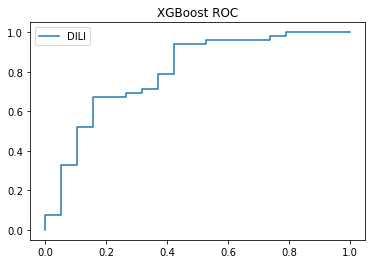

In [75]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test[:], clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="DILI")

# fpr, tpr, thresholds = roc_curve(y_test[:, 1], model.proba(X_test)[:, 1])
# plt.plot(fpr, tpr, label="Agonist/antagonist")
plt.legend()
plt.title("XGBoost ROC")

In [77]:
clf.save_model("weights/dili")

## TabNet experiments

In [157]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [158]:
clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=4e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model 
clf1_nopreproc.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['auc','accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=64, virtual_batch_size=32,
    num_workers=1,
    weights=1,
    drop_last=False
)          

Device used : cuda
epoch 0  | loss: 0.812   | train_auc: 0.61122 | train_accuracy: 0.49186 | valid_auc: 0.62329 | valid_accuracy: 0.47364 |  0:00:03s
epoch 1  | loss: 0.70737 | train_auc: 0.57283 | train_accuracy: 0.50814 | valid_auc: 0.57392 | valid_accuracy: 0.52636 |  0:00:07s
epoch 2  | loss: 0.68976 | train_auc: 0.62654 | train_accuracy: 0.56201 | valid_auc: 0.6343  | valid_accuracy: 0.56942 |  0:00:11s
epoch 3  | loss: 0.67961 | train_auc: 0.61958 | train_accuracy: 0.57586 | valid_auc: 0.64429 | valid_accuracy: 0.5993  |  0:00:15s
epoch 4  | loss: 0.66531 | train_auc: 0.63883 | train_accuracy: 0.4945  | valid_auc: 0.66854 | valid_accuracy: 0.4754  |  0:00:19s
epoch 5  | loss: 0.65684 | train_auc: 0.63892 | train_accuracy: 0.60246 | valid_auc: 0.66013 | valid_accuracy: 0.61511 |  0:00:23s
epoch 6  | loss: 0.6452  | train_auc: 0.67836 | train_accuracy: 0.62885 | valid_auc: 0.68343 | valid_accuracy: 0.64938 |  0:00:27s
epoch 7  | loss: 0.61543 | train_auc: 0.71867 | train_accuracy: 